# Conditional Diffusion

Guide molecule generation with diffusion models using properties.

## Import Libraries and Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Descriptors
import selfies as sf
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Preprocess Dataset

We will be using the Zinc-250k dataset to demonstrate this model. SELFIES are used instead of SMILES to ensure a valid molecule is being generated. This is because each SELFIES string always encodes a valid molecule.

In [2]:
class SELFIESDataset(Dataset):
    def __init__(self, smiles_list, max_len=100):
        self.max_len = max_len
        self.selfies_list = []

        # converting SMILES to SELFIES
        for s in smiles_list:
            try:
                mol = Chem.MolFromSmiles(s)
                if mol:
                    selfies = sf.encoder(Chem.MolToSmiles(mol))
                    self.selfies_list.append(selfies)
            except:
                pass

        # Build SELFIES alphabet
        alphabet = set()
        for s in self.selfies_list:
            alphabet.update(sf.split_selfies(s))
        self.alphabet = ['<PAD>', '<START>', '<END>'] + sorted(list(alphabet))

        # Mappings
        self.char_to_idx = {c: i for i, c in enumerate(self.alphabet)}
        self.idx_to_char = {i: c for i, c in enumerate(self.alphabet)}
        self.vocab_size = len(self.alphabet)

    def selfies_to_token(self, selfies):
        # To convert SELFIES to tokens
        tokens = [self.char_to_idx['<START>']]
        tokens.extend([self.char_to_idx.get(ch, 0) for ch in sf.split_selfies(selfies)])
        tokens.append(self.char_to_idx['<END>'])

        # Pad or truncate
        if len(tokens) < self.max_len:
            tokens.extend([self.char_to_idx['<PAD>']] * (self.max_len - len(tokens)))
        else:
            tokens = tokens[:self.max_len]

        return torch.tensor(tokens, dtype=torch.long)

    def token_to_smiles(self, tokens):
        # To convert tokens back to SMILES
        chars = []
        for idx in tokens:
            char = self.idx_to_char[idx]
            if char == '<END>':
                break
            if char not in ['<PAD>', '<START>']:
                chars.append(char)
        selfies = ''.join(chars)
        try:
            smiles = sf.decoder(selfies)
            return smiles
        except:
            return ''

    def compute_logp(self, smiles):
        # Compute LogP using RDKit
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol:
                return Descriptors.MolLogP(mol)
        except:
            pass
        return 0.0

    def __len__(self):
        return len(self.selfies_list)

    def __getitem__(self, idx):
        selfies = self.selfies_list[idx]
        smiles = sf.decoder(selfies)
        tokens = self.selfies_to_token(selfies)
        logp = self.compute_logp(smiles)
        return {
            'tokens': tokens,
            'logp': torch.tensor([logp], dtype=torch.float32)
        }


In [11]:
import requests
import io
import pandas as pd

# Read CSV file
try:
    url = "https://raw.githubusercontent.com/aspuru-guzik-group/chemical_vae/master/models/zinc_properties/250k_rndm_zinc_drugs_clean_3.csv"
    response = requests.get(url)
    response.raise_for_status()
    df = pd.read_csv(io.StringIO(response.text))
except Exception:
    df = pd.read_csv("zinc250k.csv")

if 'smiles' in df.columns:
    all_smiles = df['smiles'].tolist()
elif 'SMILES' in df.columns:
    all_smiles = df['SMILES'].tolist()
else:
    # If column name is different, use first column
    all_smiles = df.iloc[:, 0].tolist()

print(f"\nTotal SMILES found: {len(all_smiles)}")



Total SMILES found: 249455


### Cleaning the dataset and making the PyTorch dataloaders

In [8]:
sample_smiles = []
for smiles in tqdm(all_smiles[:50000], desc="Validating"):
    if pd.notna(smiles) and isinstance(smiles, str) and len(smiles) > 0:
        # Validate with RDKit
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is not None:
                # Canonicalize SMILES
                canonical_smiles = Chem.MolToSmiles(mol)
                if 5 < len(canonical_smiles) < 100:  # Keep reasonable length
                    sample_smiles.append(canonical_smiles)
        except:
            pass


dataset = SELFIESDataset(sample_smiles, max_len=100)

dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)  # Larger batch size

Validating: 100%|██████████| 50000/50000 [00:12<00:00, 4148.99it/s]


## Denoiser: A simple Transformer

In [3]:
class SimpleTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=256, nhead=8, num_layers=4,
                 max_len=100):
        super().__init__()

        self.d_model = d_model

        # Embeddings
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(max_len, d_model)

        # Time embedding (for diffusion timestep)
        self.time_mlp = nn.Sequential(
            nn.Linear(1, d_model),
            nn.SiLU(),
            nn.Linear(d_model, d_model)
        )

        # Conditional embedding (for property like LogP)
        self.cond_mlp = nn.Sequential(
            nn.Linear(1, d_model),
            nn.SiLU(),
            nn.Linear(d_model, d_model)
        )

        # Transformer layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model*4,
            dropout=0.1,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Output layer
        self.output = nn.Linear(d_model, vocab_size)

    def forward(self, x, t, condition):
        batch_size, seq_len = x.shape

        # Token + Position embeddings
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, -1)
        x = self.token_embedding(x) + self.position_embedding(positions)

        # Add time embedding
        t_emb = self.time_mlp(t).unsqueeze(1)
        x = x + t_emb

        # Add conditional embedding
        cond_emb = self.cond_mlp(condition).unsqueeze(1)
        x = x + cond_emb

        # Transformer
        x = self.transformer(x)

        # Output logits
        return self.output(x)

## Diffusion Model

Discrete Diffusion Model for SELFIES token generation.  The tokens are corrupted (noised) using a corruption probability $p$. This corruption probability increases with timesteps. So, the model learns by corrupting a token at a random timestep and trying to reconstruct the token. 

In [4]:

class DiscreteDiffusion(nn.Module):
    def __init__(self, model, vocab_size, timesteps=1000):
        super().__init__()

        self.model = model
        self.vocab_size = vocab_size
        self.timesteps = timesteps

        # Beta schedule (small to moderate corruption)
        self.betas = torch.linspace(0.0001, 0.02, timesteps)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)

        self.register_buffer('betas_buffer', self.betas)
        self.register_buffer('alphas_cumprod_buffer', self.alphas_cumprod)

    def q_sample(self, x_0, t):
        batch_size, seq_len = x_0.shape

        # corruption probability increases as timesteps grow:
        corruption_prob = (1.0 - self.alphas_cumprod_buffer[t]).view(-1, 1)  # [batch, 1]
        corruption_prob = corruption_prob.expand(-1, seq_len)               # [batch, seq_len]

        noise = torch.randint(0, self.vocab_size, (batch_size, seq_len), device=x_0.device)

        mask = torch.rand(batch_size, seq_len, device=x_0.device) < corruption_prob

        x_t = torch.where(mask, noise, x_0)

        return x_t, mask, noise

    def p_sample(self, x_t, t, condition=None):
        batch_size, seq_len = x_t.shape

        t_normalized = t.float().unsqueeze(1) / float(self.timesteps)

        logits = self.model(x_t, t_normalized, condition)  # [batch, seq_len, vocab]

        if (t == 0).all():
            return torch.argmax(logits, dim=-1)

        probs = F.softmax(logits, dim=-1)  # [batch, seq_len, vocab]
        probs_rows = probs.view(-1, self.vocab_size)                     # [batch*seq_len, vocab]
        samples = torch.multinomial(probs_rows, num_samples=1).squeeze(-1)  # [batch*seq_len]
        x_t_minus_1 = samples.view(batch_size, seq_len)                  # [batch, seq_len]

        return x_t_minus_1

    def forward(self, x_0, condition=None):
        batch_size = x_0.shape[0]

        t = torch.randint(0, self.timesteps, (batch_size,), device=x_0.device, dtype=torch.long)

        x_t, mask, _ = self.q_sample(x_0, t)
        t_normalized = t.float().unsqueeze(1) / float(self.timesteps)
        pred_logits = self.model(x_t, t_normalized, condition)  # [batch, seq_len, vocab]

        # Compute token-wise cross-entropy
        ce = F.cross_entropy(pred_logits.view(-1, self.vocab_size), x_0.view(-1), reduction='none')
        ce = ce.view(batch_size, -1)  # [batch, seq_len]

        mask_float = mask.float()
        # Avoid division by zero: if no masked tokens in a batch row, treat as zero contribution
        denom = mask_float.sum(dim=1).clamp(min=1.0)  # [batch]
        loss_per_example = (ce * mask_float).sum(dim=1) / denom  # [batch]

        loss = loss_per_example.mean()

        return loss

    @torch.no_grad()
    def sample(self, batch_size, seq_len, condition=None, num_steps=None):
        # generate new samples by iterative denoising.
        if num_steps is None:
            num_steps = self.timesteps

        # Start from pure noise tokens
        x = torch.randint(0, self.vocab_size, (batch_size, seq_len), device=self.alphas_cumprod_buffer.device)

        timesteps_to_run = torch.linspace(self.timesteps - 1, 0, steps=num_steps, dtype=torch.long).to(x.device)

        for i in tqdm(timesteps_to_run, desc="Sampling"):
            t = torch.full((batch_size,), int(i.item()), device=x.device, dtype=torch.long)
            x = self.p_sample(x, t, condition)

        return x

## Training the model

In [11]:

def train_diffusion(model, dataloader, optimizer, epochs=10):
    model.train()
    losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")

        for batch in pbar:
            tokens = batch['tokens'].to(device)
            logp = batch['logp'].to(device)

            if logp is not None:
                logp = (logp - logp.mean()) / (logp.std() + 1e-8)

            loss = model(tokens, condition=logp)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            epoch_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1} - Average Loss: {avg_loss:.4f}")

    return losses

## Initializing model, setting optimizer and training model

In [13]:
conditional_model = SimpleTransformer(
    vocab_size=dataset.vocab_size,
    d_model=256,  # Increased capacity
    nhead=8,
    num_layers=6,  # More layers
    max_len=100,
).to(device)

diffusion_cond = DiscreteDiffusion(
    conditional_model,
    vocab_size=dataset.vocab_size,
    timesteps=1000  # More timesteps
).to(device)

optimizer = torch.optim.AdamW(diffusion_cond.parameters(), lr=1e-4, weight_decay=0.01)
losses_cond = train_diffusion(diffusion_cond, dataloader, optimizer, epochs=20)  # More epochs


Epoch 1/20: 100%|██████████| 782/782 [00:26<00:00, 29.44it/s, loss=0.8830]


Epoch 1 - Average Loss: 1.0473


Epoch 2/20: 100%|██████████| 782/782 [00:24<00:00, 31.30it/s, loss=0.9060]


Epoch 2 - Average Loss: 0.9498


Epoch 3/20: 100%|██████████| 782/782 [00:25<00:00, 30.56it/s, loss=0.8426]


Epoch 3 - Average Loss: 0.9401


Epoch 4/20: 100%|██████████| 782/782 [00:25<00:00, 31.24it/s, loss=1.0765]


Epoch 4 - Average Loss: 0.9323


Epoch 5/20: 100%|██████████| 782/782 [00:26<00:00, 29.57it/s, loss=1.0068]


Epoch 5 - Average Loss: 0.9245


Epoch 6/20: 100%|██████████| 782/782 [00:25<00:00, 30.98it/s, loss=0.8756]


Epoch 6 - Average Loss: 0.9091


Epoch 7/20: 100%|██████████| 782/782 [00:25<00:00, 31.15it/s, loss=0.6829]


Epoch 7 - Average Loss: 0.8869


Epoch 8/20: 100%|██████████| 782/782 [00:25<00:00, 30.66it/s, loss=0.8234]


Epoch 8 - Average Loss: 0.8728


Epoch 9/20: 100%|██████████| 782/782 [00:25<00:00, 30.51it/s, loss=0.7727]


Epoch 9 - Average Loss: 0.8538


Epoch 10/20: 100%|██████████| 782/782 [00:24<00:00, 31.58it/s, loss=0.8093]


Epoch 10 - Average Loss: 0.8461


Epoch 11/20: 100%|██████████| 782/782 [00:25<00:00, 30.76it/s, loss=0.8084]


Epoch 11 - Average Loss: 0.8374


Epoch 12/20: 100%|██████████| 782/782 [00:25<00:00, 30.67it/s, loss=0.9099]


Epoch 12 - Average Loss: 0.8319


Epoch 13/20: 100%|██████████| 782/782 [00:26<00:00, 30.05it/s, loss=0.6841]


Epoch 13 - Average Loss: 0.8264


Epoch 14/20: 100%|██████████| 782/782 [00:25<00:00, 30.41it/s, loss=0.9110]


Epoch 14 - Average Loss: 0.8219


Epoch 15/20: 100%|██████████| 782/782 [00:24<00:00, 31.85it/s, loss=0.7500]


Epoch 15 - Average Loss: 0.8230


Epoch 16/20: 100%|██████████| 782/782 [00:28<00:00, 27.70it/s, loss=0.8684]


Epoch 16 - Average Loss: 0.8199


Epoch 17/20: 100%|██████████| 782/782 [00:26<00:00, 29.23it/s, loss=0.7810]


Epoch 17 - Average Loss: 0.8141


Epoch 18/20: 100%|██████████| 782/782 [00:25<00:00, 30.88it/s, loss=0.8475]


Epoch 18 - Average Loss: 0.8095


Epoch 19/20: 100%|██████████| 782/782 [00:25<00:00, 31.13it/s, loss=0.9049]


Epoch 19 - Average Loss: 0.8082


Epoch 20/20: 100%|██████████| 782/782 [00:25<00:00, 30.83it/s, loss=0.8943]


Epoch 20 - Average Loss: 0.8068


### Visualizing Loss Curves

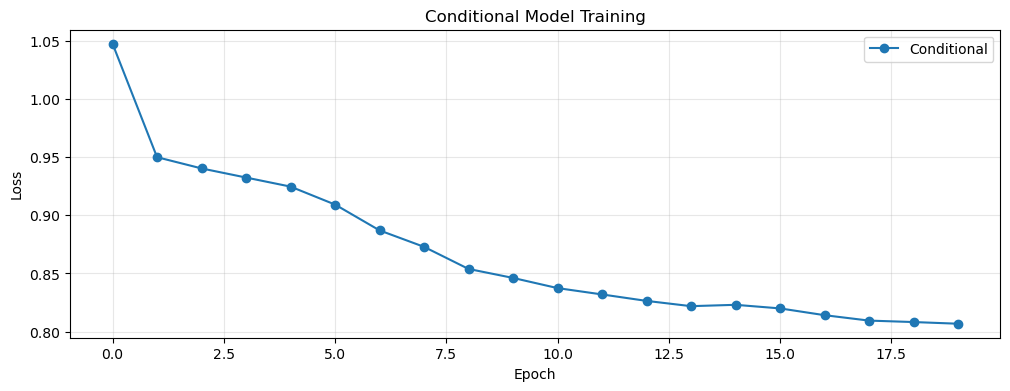

In [15]:
plt.figure(figsize=(12, 4))
plt.plot(losses_cond, label='Conditional', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Conditional Model Training')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

## Generate Molecules

### Generating molecules with high $logP$ ~ $4.0$

In [ ]:
high_logp_condition = torch.tensor([[4.0]], device=device).repeat(10, 1)
# Normalize (based on ZINC250k statistics: mean~2.5, std~1.5)
high_logp_condition = (high_logp_condition - 2.5) / 1.5

with torch.no_grad():
    generated_tokens = diffusion_cond.sample(batch_size=10, seq_len=100, condition=high_logp_condition, num_steps=100)

    valid_count = 0
    for i, tokens in enumerate(generated_tokens):
        smiles = dataset.token_to_smiles(tokens.cpu().numpy())
        mol = Chem.MolFromSmiles(smiles)

        if mol:
            logp = Descriptors.MolLogP(mol)
            mw = Descriptors.MolWt(mol)
            print(f"  {i+1}. {smiles}")
            print(f"      LogP: {logp:.2f}, MW: {mw:.2f}")
            valid_count += 1
        else:
            print(f"  {i+1}. {smiles} (Invalid)")

    print(f"\nValidity: {valid_count}/10 = {valid_count*10}%")

### Generating molecules with low $logP$ ~ $1.0$

In [ ]:
low_logp_condition = torch.tensor([[1.0]], device=device).repeat(10, 1)
# Normalize
low_logp_condition = (low_logp_condition - 2.5) / 1.5

with torch.no_grad():
    generated_tokens = diffusion_cond.sample(batch_size=10, seq_len=100, condition=low_logp_condition, num_steps=100)

    valid_count = 0
    for i, tokens in enumerate(generated_tokens):
        smiles = dataset.token_to_smiles(tokens.cpu().numpy())
        mol = Chem.MolFromSmiles(smiles)

        if mol:
            logp = Descriptors.MolLogP(mol)
            mw = Descriptors.MolWt(mol)
            print(f"  {i+1}. {smiles}")
            print(f"      LogP: {logp:.2f}, MW: {mw:.2f}")
            valid_count += 1
        else:
            print(f"  {i+1}. {smiles} (Invalid)")

    print(f"\nValidity: {valid_count}/10 = {valid_count*10}%")